## Total Energy Pre-Processed Data Check

[Home Page](https://john-grando.github.io/)

This notebook provides a preliminary look at the preprocessed data for the U.S. total energy dataset from the EIA bulk file download website.  A simple join operation operation and graphics are created to ensure the data is usable and makes sense, so that further analyses can be performed.  In this check, we look at the net generation categories which are used for time series analysis in a separate [notebook](https://john-grando.github.io/EIADataPages/total_energy_prediction.html).

### Initial Setup

In [1]:
import os, sys, re
import pprint as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib widget
%matplotlib inline

py_file_path = os.path.join(
    os.getcwd(),
    "..",
    ".."
)

sys.path.append(py_file_path)
from app.SparkTools import MyPySpark

MySpark = None

#ensure only one sc and spark instance is running
global MySpark
MySpark = MySpark or MyPySpark(
    master = 'local[3]', 
    logger_name = 'jupyter')

### Create Function for Plotting Outputs in a Batch

In [2]:
def get_categories(
    in_df, 
    category_rgx,
    unit_rgx,
    filter_column_name = "name", 
    filter_column_units = "units",
    numeric_column = "value"):
    metrics_s = {
        (i, j) for i,j in zip(in_df[filter_column_name], in_df[filter_column_units]) 
        if 
            (match:=re.search(category_rgx, i, re.IGNORECASE))
            and (match:=re.search(unit_rgx, j, re.IGNORECASE)) 
    }

    df = in_df.loc[
        (
            in_df[filter_column_name].isin(
                [i for i, j in metrics_s])
        )].copy()

    
    plot_d = {
        'df': df,
        'groups' : [re.match(r'^[^,]+', i).group(0) for i in df[filter_column_name]],
        'data_col' : numeric_column,
        'metrics_s' : metrics_s
    }
    
    return  plot_d

### Process Data

In [3]:
import pyspark.sql.functions as pysF

name_rgx = [
    "(?=Net Generation).*(All Sectors, Monthly)$",
    "(?=Net Generation).*(Commercial Sector, Monthly)$",
    "(?=Net Generation).*(Electric Power Sector, Monthly)$",
    "(?=Net Generation).*(Industrial Sector, Monthly)$",
]
unit_rgx = [
    "Million Kilowatthours"
]

total_energy_dim_df = MySpark\
    .spark\
    .read\
    .parquet("/Processed/TotalEnergyDimDF")\
    .select("series_id", "name", "units")\
    .filter(pysF.col("name").rlike("|".join(name_rgx)))\
    .filter(pysF.col("units").rlike("|".join(unit_rgx)))

total_energy_fact_df = MySpark\
    .spark\
    .read\
    .parquet("/Processed/TotalEnergyFactDF")

total_energy_df = total_energy_fact_df.join(
    pysF.broadcast(total_energy_dim_df),
    on = "series_id",
    how = "right")\
    .withColumn(
        "value",
        pysF.col("value").cast("float"))\
    .toPandas()\
    .astype(
        {
            "value":"float64",
            "date":"datetime64[ns]"
        }
    )

The 'All Sectors' groups appear to have data recorded for the entire time series history while there appears to be missing data for some of the subsectors.  Overall, the selected data for this preliminary evaluation seems to be intact and well labeled.

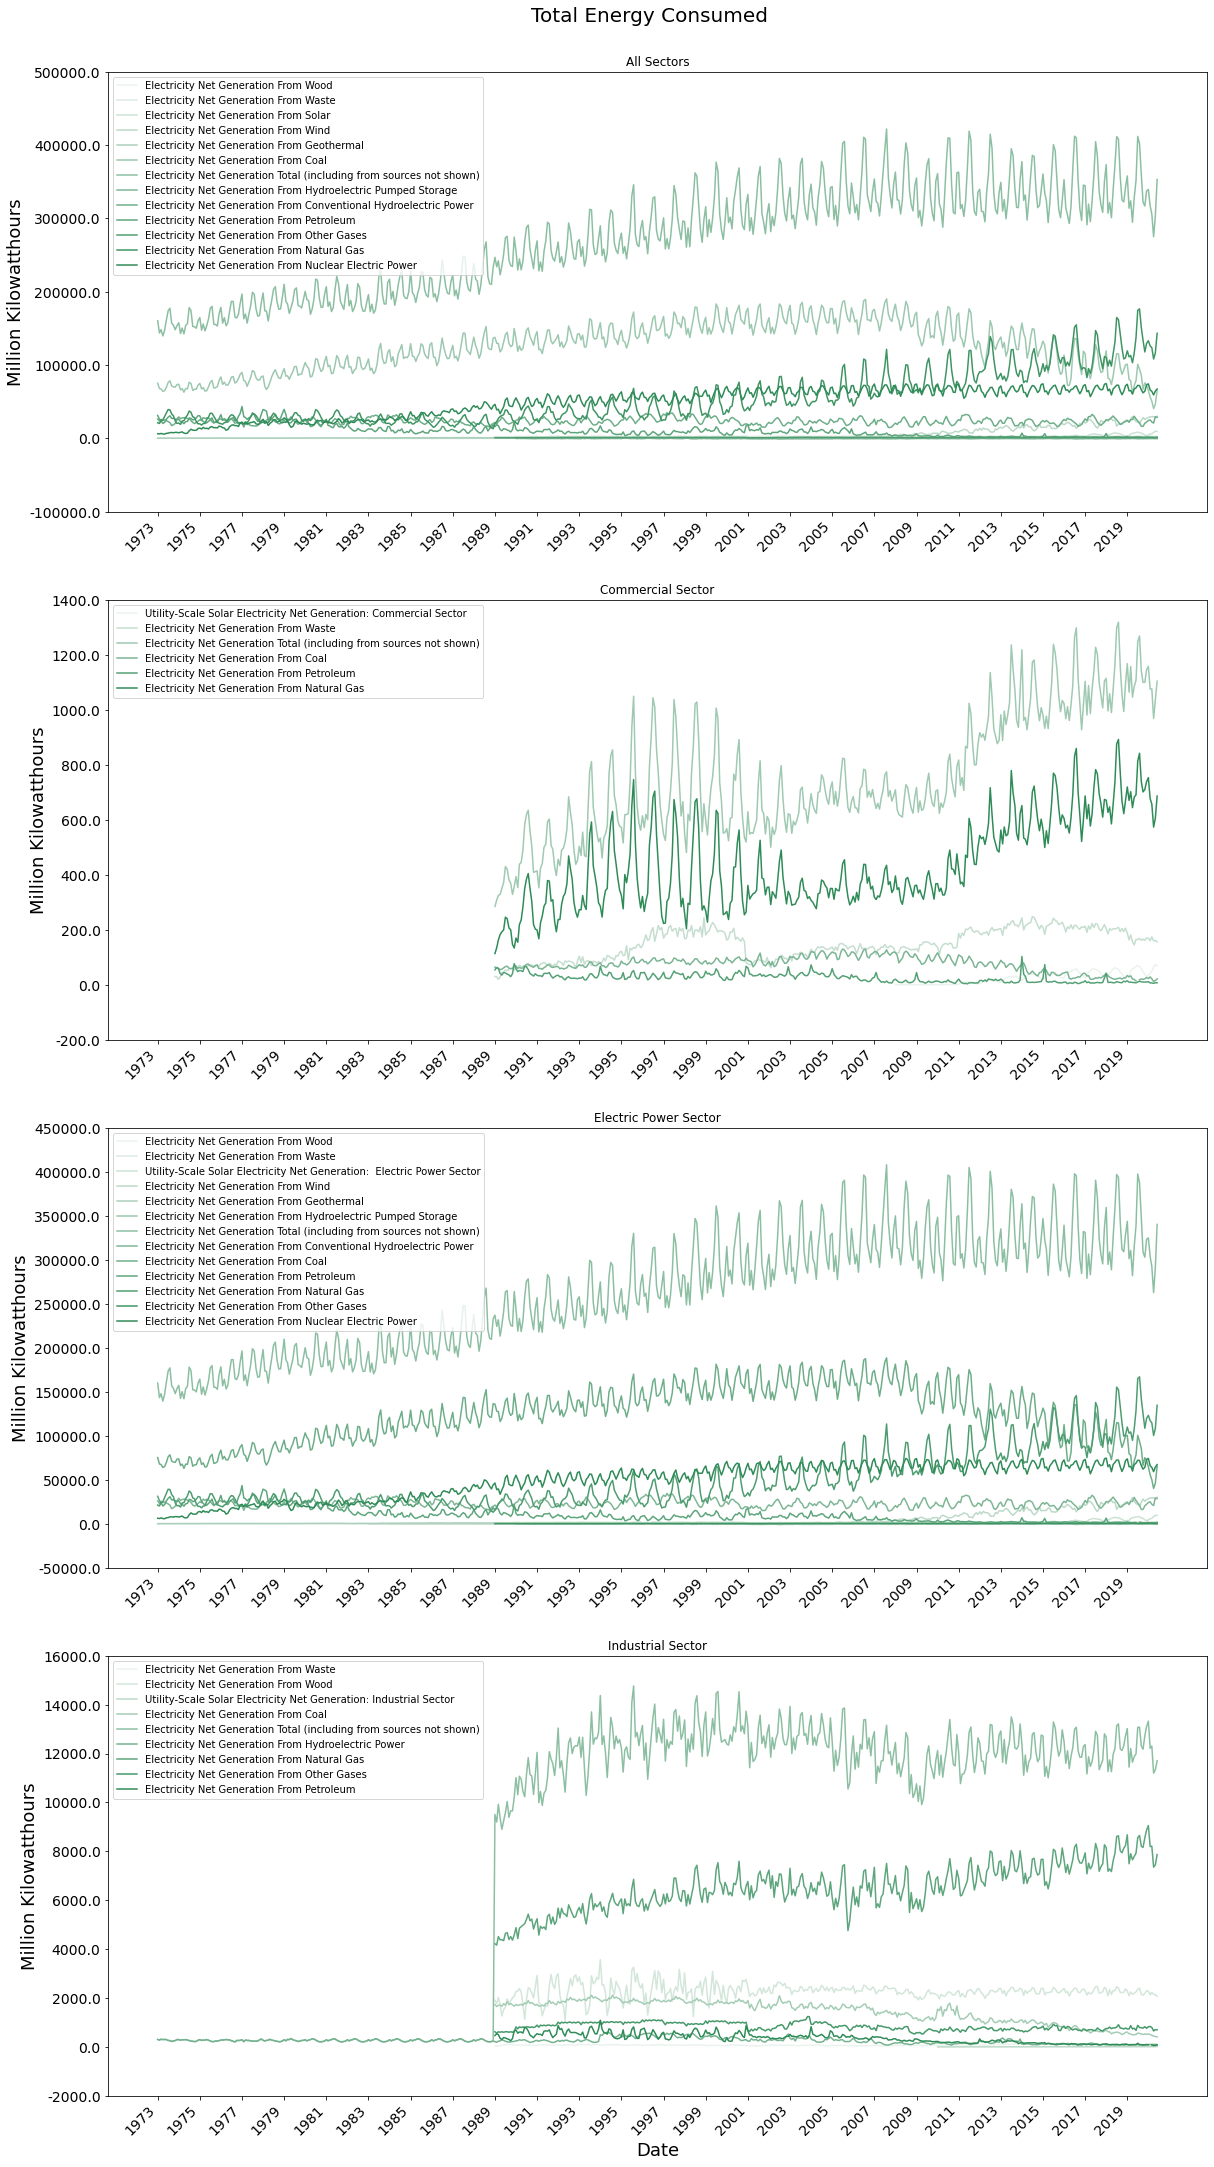

In [4]:
plot_input_l = []
title_l = ["All Sectors", "Commercial Sector", "Electric Power Sector", "Industrial Sector"]
for c_rgx, u_rgx, title in (
    zip(name_rgx, unit_rgx * len(name_rgx), title_l)):    
    plot_d = get_categories(
        in_df = total_energy_df, 
        category_rgx = c_rgx,
        unit_rgx = u_rgx)
    plot_d['date_col'] = 'date'
    plot_d['date_fmt'] = "%Y"
    plot_d['palette'] = sns.light_palette(
            "seagreen", 
            n_colors=len(set(plot_d['groups'])))
    plot_d['title'] = title
    plot_input_l.append(plot_d)
    
font_scale = 1
fig, axs = plt.subplots(len(plot_input_l), 1, figsize=(16,30), sharex=True)
fig.tight_layout()
plt.subplots_adjust(top = 0.95, hspace = 0.2)

for ax, p_d in zip(axs, plot_input_l):
    ax = sns.lineplot(
        data = p_d["df"],
        x = p_d["df"][p_d["date_col"]],
        y = p_d["df"][p_d["data_col"]],
        hue = p_d["groups"],
        ci = None,
        palette = p_d["palette"],
        ax = ax
    )
    ax.set_xlabel(
        "Date", 
        fontsize = 18 * font_scale)
    ax.set_ylabel(
        ", ".join(list({j for i, j in p_d['metrics_s']})),
        fontsize = 18 * font_scale)
    ax.set_xticks(p_d['df'][p_d["date_col"]].dt.strftime(p_d["date_fmt"]).sort_values().unique().tolist()[::2])
    ax.set_xticklabels(
        labels=p_d['df'][p_d["date_col"]].dt.strftime(p_d["date_fmt"]).sort_values().unique().tolist()[::2],
        rotation=45, 
        ha='right',
        fontsize = 14 * font_scale)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(
        labels = ax.get_yticks(),
        fontsize = 14 * font_scale)
    ax.set_title(p_d["title"])
    ax.xaxis.set_tick_params(which='both', labelbottom=True) #show ticks in all subplots (sharex turns it off)


fig.suptitle("Total Energy Consumed", fontsize = 20 * font_scale);